In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in pixel data

In [19]:
file_pixel = "./data/pixel_color.txt"
file_colormap = "./data/colormap.txt"

In [69]:
# read in pixel
lines = open(file_pixel).read().strip().split('\n')
lines = [line.split() for line in lines] 
pixel_lines = [[int(d) for d in line] for line in lines]
# display the first 10 pixels for the first image
pixel_lines[0][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [93]:
# read in colormap:
lines = open(file_colormap).read().strip().split('\n')
colormap = {i:[int(num) for num in line.split()] for i,line in enumerate(lines)}
num_of_colors = len(lines) + 1 # plus EOP(End of Pixel) marker

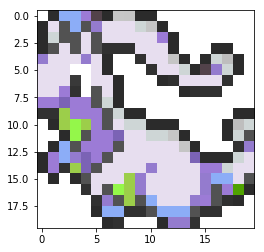

In [94]:
import cv2
def line2img(line,colormap):
    #img = np.zeros([20,20,3])
    img = np.array([colormap[color] for color in line])
    img = img.reshape(20,20,3)/255
    plt.imshow(img)
    return img

image0 = line2img(pixel_lines[35],colormap)
image1 = line2img(pixel_lines[132],colormap)

## Transfer it to Pytorch tensor

In [271]:
def line2tensor(line):
    tensor = torch.zeros(len(line),1,num_of_colors)
    for i, color in enumerate(line):
        tensor[i][0][color] = 1
    return tensor

tensor0 = line2tensor(pixel_lines[0])
#tensor0.data

## Prepare input data and output data
1. input: pixel
2. output: next pixel

In [205]:
def targetTensor(line):
    pixel_indexes = [color for color in line[1:]]
    pixel_indexes.append(num_of_colors-1)
    return torch.LongTensor(pixel_indexes)
#targetTensor(pixel_lines[132])

In [208]:
import random
def randomTrainingSet():
    line = pixel_lines[random.randint(0,len(pixel_lines)-1)]
    input_line_tensor = Variable(line2tensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return input_line_tensor, target_line_tensor

randomTrainingSet()

(Variable containing:
 ( 0 ,.,.) = 
    1   0   0  ...    0   0   0
 
 ( 1 ,.,.) = 
    1   0   0  ...    0   0   0
 
 ( 2 ,.,.) = 
    1   0   0  ...    0   0   0
 ... 
 
 (397,.,.) = 
    1   0   0  ...    0   0   0
 
 (398,.,.) = 
    1   0   0  ...    0   0   0
 
 (399,.,.) = 
    1   0   0  ...    0   0   0
 [torch.FloatTensor of size 400x1x168], Variable containing:
    0
    0
    0
    1
  116
  116
   43
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
  116
  116
   43
    4
    2
    0
    0
   16
    2
   10
    0
    0
    0
    0
    0
    0
    0
    0
    0
    1
   25
  124
   45
   45
   45
   22
    2
   41
   41
   41
   34
    0
    0
    0
    0
    0
    0
    0
    1
  124
   35
   35
   35
   45
   45
   32
   41
  116
  116
   16
    0
    0
    0
    0
    5
   10
   36
    2
  125
   35
   35
   35
   45
   45
  125
   69
  116
  116
   43
    0
    0
    0
    0
    0
   47
    9
   47
   46
  124
 

## Creating the Network
We will train a LSTM

In [299]:
import torch.nn as nn
from torch.autograd import Variable
lstm = nn.LSTMCell(input_size=num_of_colors,hidden_size= 500)
input = Variable(tensor0)
input = Variable(torch.randn(10,1,168))
h0 = Variable(torch.randn(1,500))
c0 = Variable(torch.randn(1,500))
i = input[0].view(1,1,168)
h,c=lstm(input[0],(h0,c0))
#output[:,-1,:]
input

ValueError: not enough values to unpack (expected 2, got 1)

In [300]:
class pixelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(pixelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x, state):
        # Forward propagate
        #x = x.view(1,1, 168)
        hn, cn = lstm(x,state)
        #print('testing')
        # output layer
        output = self.out(hn)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hn, cn 
    
    def initHiddenCell(self):
        # Set initial states
        h0 = Variable(torch.randn(1, self.hidden_size))
        c0 = Variable(torch.randn(1, self.hidden_size))
        return h0,c0

## Training the Network

In [301]:
criterion = nn.NLLLoss()
learning_rate = 0.0005
optimizer = torch.optim.ASGD(prnn.parameters(),lr = learning_rate)

def train(input_line_tensor, target_line_tensor):
    h, c = prnn.initHiddenCell()
    prnn.zero_grad()
    loss = 0
    #print('initialized')
    for i in range(input_line_tensor.size()[0]):
        state = (h,c)
        output, h, c = prnn(input_line_tensor[i], state)
        loss += criterion(output, target_line_tensor[i])
    
    loss.backward()
    optimizer.step()
    return output, loss.data[0] / input_line_tensor.size()[0]

In [302]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [303]:
#prnn(tensor0,(h0,c0))
#tensor0.data

start to train

In [304]:
prnn = pixelRNN(num_of_colors,500,num_of_colors)

n_epochs = 100000
print_every = 200
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every epochs

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*randomTrainingSet())
    total_loss += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
    

5m 9s (200 0%) 5.1243
10m 19s (400 0%) 5.1306
15m 29s (600 0%) 5.1240
20m 28s (800 0%) 5.1223
26m 1s (1000 1%) 5.1311
30m 57s (1200 1%) 5.1251
36m 23s (1400 1%) 5.1294
41m 21s (1600 1%) 5.1261
46m 14s (1800 1%) 5.1292
51m 1s (2000 2%) 5.1286
56m 1s (2200 2%) 5.1331
61m 9s (2400 2%) 5.1279
65m 56s (2600 2%) 5.1272
70m 42s (2800 2%) 5.1310
76m 2s (3000 3%) 5.1333
80m 53s (3200 3%) 5.1250
85m 46s (3400 3%) 5.1238
91m 6s (3600 3%) 5.1275
96m 19s (3800 3%) 5.1290
101m 6s (4000 4%) 5.1285
105m 52s (4200 4%) 5.1329
110m 42s (4400 4%) 5.1280
115m 51s (4600 4%) 5.1329
120m 37s (4800 4%) 5.1289
126m 1s (5000 5%) 5.1298
131m 4s (5200 5%) 5.1276
136m 26s (5400 5%) 5.1257
141m 48s (5600 5%) 5.1194
146m 37s (5800 5%) 5.1226
151m 24s (6000 6%) 5.1287
156m 35s (6200 6%) 5.1297
161m 26s (6400 6%) 5.1315
166m 14s (6600 6%) 5.1329
171m 0s (6800 6%) 5.1310
175m 54s (7000 7%) 5.1258
181m 6s (7200 7%) 5.1296
185m 52s (7400 7%) 5.1224
190m 37s (7600 7%) 5.1277
195m 23s (7800 7%) 5.1260
200m 8s (8000 8%) 5.12

KeyboardInterrupt: 

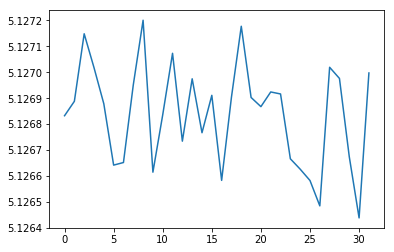

In [305]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [318]:
torch.save(prnn,'test_nn.txt')

/home/yadong/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type pixelRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [319]:
testnn = torch.load('test_nn')

In [325]:
for p in testnn.parameters():
    print(p)

Parameter containing:
 1.0358e-02  1.4160e-02  2.9849e-02  ...   2.5570e-02  3.1967e-02 -3.4716e-02
-4.4355e-02  1.4915e-02  4.1459e-02  ...   2.7248e-02  1.1324e-02 -1.4513e-03
-2.1432e-02  3.6808e-02 -2.1846e-03  ...   3.4038e-02  2.9848e-02  8.5843e-03
                ...                   ⋱                   ...                
 3.9190e-02 -7.1644e-03 -2.2700e-02  ...   3.6903e-02 -1.6429e-03  2.9166e-02
-1.7646e-02 -5.6100e-03  1.8774e-02  ...  -2.1597e-02 -9.8878e-03  1.4119e-02
-4.4037e-02 -5.7915e-03 -1.0643e-02  ...  -4.7515e-03 -1.1702e-02  7.4082e-03
[torch.FloatTensor of size 2000x168]

Parameter containing:
 7.3559e-03  1.5863e-03  8.2818e-03  ...  -4.7366e-03  3.0685e-02 -3.4934e-02
 2.6427e-02  8.7757e-03  2.4025e-03  ...   7.3876e-03 -8.3154e-03  1.9757e-02
-3.8310e-02 -1.7329e-02 -1.4713e-02  ...  -1.9512e-03 -1.5263e-02 -2.4538e-02
                ...                   ⋱                   ...                
-1.4424e-02 -7.0608e-03 -1.0991e-02  ...  -1.5168e-02 -4.882

In [326]:
testnn.parameters

<bound method Module.parameters of pixelRNN (
  (lstm): LSTMCell(168, 500)
  (out): Linear (500 -> 168)
  (dropout): Dropout (p = 0.2)
  (softmax): LogSoftmax ()
)>